In [1]:
def ddqn_tester(env, train_st_fc, 
               load_data, generation_data, feature, 
               summer_TOU, winter_TOU, 
               T ,Tf, start_day, battery_max,
               path):
    
    q = Qnet(feature)
    q.load_state_dict(torch.load(path))
    
    # test 시작
    train_st = train_st_fc()

    state = env.initialize_state(feature, T, load_data, generation_data, Tf, start_day, summer_TOU, winter_TOU)

    battery, action = 0, 0

    cost_history, battery_history,action_history = [],[],[]

    for n_epi in range(days):
        TOU = summer_TOU
        cum_cost, day_action, day_battery = 0, [] , []

        for time in range(0, 24):
            battery = state[0] - state[50] + state[51+Tf]
            if battery > battery_max: battery = battery_max
            action = train_st.select_action(q, torch.from_numpy(state).float(), battery, battery_max)

            day_action.append(action)
            day_battery.append(state[0])

            new_state, reward = env.step(n_epi=n_epi, time=time, battery=battery, charge=action, 
                                            day_charge=day_action, TOU=TOU, Tf=Tf)
            cum_cost = cum_cost + reward

            state = new_state

        cost_history.append(cum_cost)
        action_history.append(day_action)
        battery_history.append(day_battery)
    return cost_history, action_history, battery_history

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

from utills import load_and_generte, charge_graph
from model import Qnet
from env import Environment
from strategy import GreedyStrategy
from glob import glob
f_load = pd.read_csv('1년치 소비데이터.csv')

f_generation = pd.read_csv("태양광데이터1.csv",encoding='cp949')

# test 시에는 30~60일로 (traion은 0~30)
start_day = 30 # 인덱스
end_day = 60 #인덱스
days = end_day-start_day
pos_name = '영암에프원태양광b'

load_data, generation_data = load_and_generte(f_load, f_generation, pos_name, start_day, end_day)

T = np.identity(n=24, dtype=np.uint8)

winter_TOU = [5,5,5, 5,5,5, 5,15,15, 15,25,10, 10,10,10, 10,10,15, 15,5,5, 5,5,5]  # 겨울
summer_TOU = [5,5,5, 5,5,5, 5,10,10 ,10,10,15, 15,15,15, 15,15,10, 10,5,5,5,5,5]  #여름

gamma = 0.98
Tf= 0
feature = 52 + 2*Tf
battery_max = 40
pD=30

# 기학습된 모델 load
paths = glob('weight/DDQN/*')

# 환경 정의
env = Environment(feature, load_data, generation_data,days,T,pD,)
config = {
    "env":env, 
    "train_st_fc":GreedyStrategy, 
    "load_data":load_data, 
    "generation_data":generation_data,
    "feature":feature, 
    "summer_TOU":summer_TOU, 
    "winter_TOU":winter_TOU, 
    "T":T,
    "Tf":Tf, 
    "start_day":start_day, 
    "battery_max":battery_max,
}
cost_dict, action_dict, battery_dict = {}, {}, {}

for path in paths:
    cfg = config.copy()
    cfg['path'] = path
    cost_dict[path],action_dict[path], battery_dict[path] = ddqn_tester(**cfg)

In [4]:
greedy_cost = 0
for i in range(days):
    if i < 90 or i >= 273:TOU = winter_TOU
    else: TOU = summer_TOU
    for j in range(24):
        gap = load_data[i][j] - generation_data[i][j]
        if gap < 0:
            gap = 0
        greedy_cost = greedy_cost + TOU[j] * gap
    greedy_cost = greedy_cost + 30*max(load_data[i])
print(greedy_cost)

29890


In [3]:
action_history = action_dict[paths[0]]
temp_cost = 0
for i in range(end_day-start_day):
    TOU = summer_TOU
    for j in range(24):
        temp_cost = temp_cost + action_history[i][j] * TOU[j]
    temp_cost = temp_cost + 30*max(action_history[i])
print(temp_cost)

18795


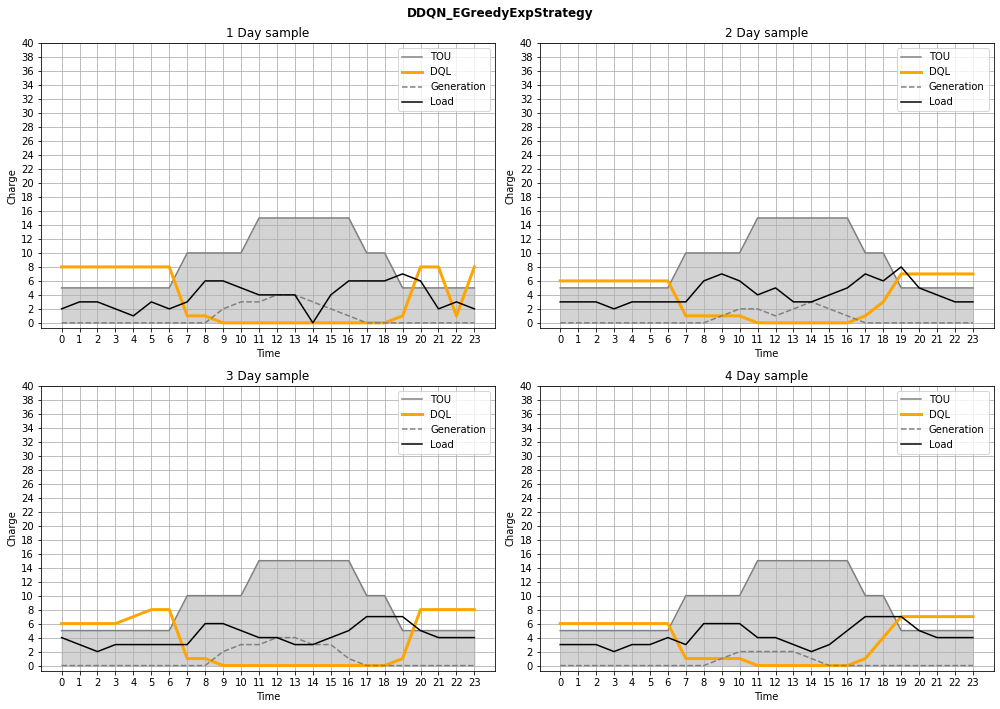

In [5]:
path = paths[0]
charge_graph(load_data, generation_data, summer_TOU, action_dict[path], battery_dict[path], path)

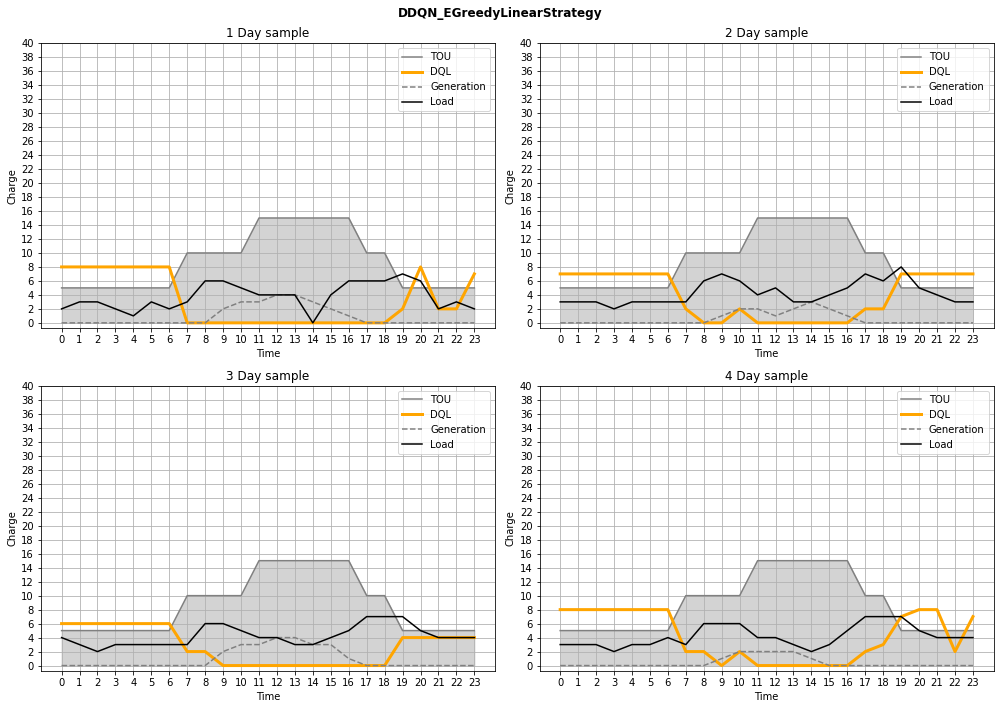

In [6]:
path = paths[1]
charge_graph(load_data, generation_data, summer_TOU, action_dict[path], battery_dict[path], path)

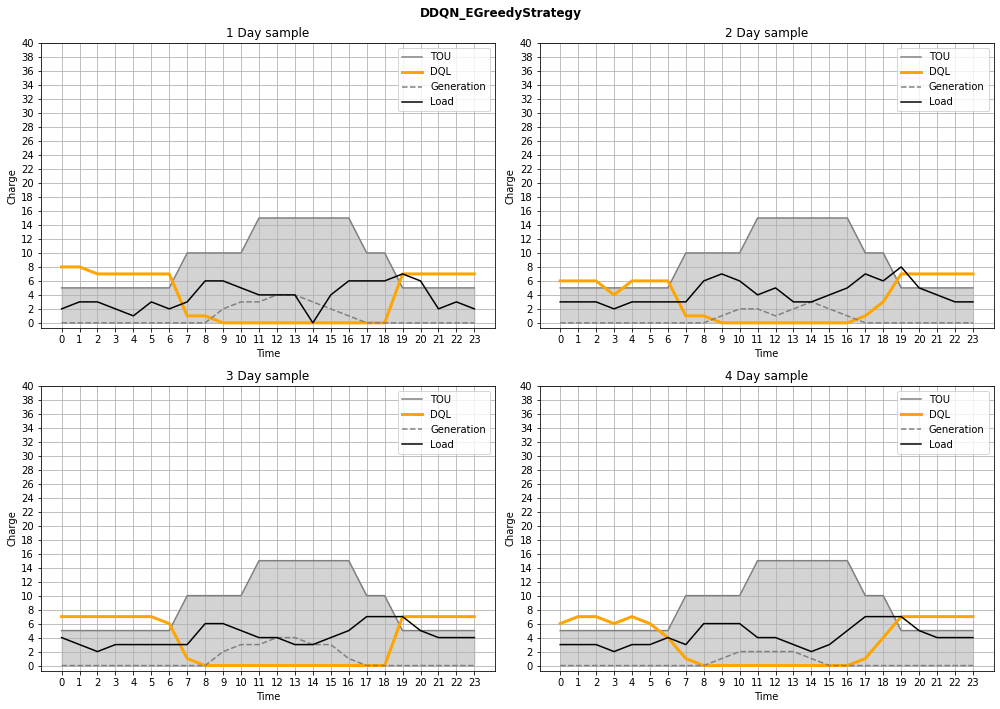

In [7]:
path = paths[2]
charge_graph(load_data, generation_data, summer_TOU, action_dict[path], battery_dict[path], path)